![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

## Multivariate Input, Univariate Output LSTM, Multistep

This tutorial is to demonstrate the process of building an LSTM model for the **Multivariate Input, Univariate Output LSTM, Multistep**. It consists of 2 major parts which are:

Part 1 - The Demonstration of Building LSTM using Synthetic data<br>
Part 2 - Exercise for building LSTM using COVID-19 Data.<br>


## What will we accomplish?
First, we will show the steps for building the LSTM :

Step 1. Data Preparation (Data Splitting, Data Sequencing, Data Standardization and Batching the Data)<br>
Step 2. Model Configuration (Vanilla LSTM, Stacked LSTM, Bidirectional LSTM)<br>
Step 3. Train the model<br>
Step 4. Validate the model using a graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>


Let's import the package needed.

In [1]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

## Hyperparameter
Define the hyperparameters that needs to be tuned in the model

In [2]:
split_ratio = 0.70
num_epochs = 300
window_size = 4
n_step = 2
learning_rate = 0.01
#seed
torch.manual_seed(123)
batch_size = 1

# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and has the ability to perform well in forecasting. <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it as a series data by using `pd.Series`.

In [3]:
#Synthetic Data
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [4]:
dataset = pd.DataFrame(dataset,columns =["in_seq1","in_seq2","out_seq"],
                      index = pd.date_range("1/1/2020",periods=len(dataset),freq='D'))
dataset.index.name="Date"
dataset.head()

,in_seq1,in_seq2,out_seq
Date,,,
2020-01-01,0,5,5
2020-01-02,10,15,25
2020-01-03,20,25,45
2020-01-04,30,35,65
2020-01-05,40,45,85


## Data Visualization
Data visualization is important for us to visualize the patterns of data such as trend and seasonality. Looking at the graph below, it is visible that there is an increasing trend in the data.

Text(0.5, 1.0, 'Synthetic Data')

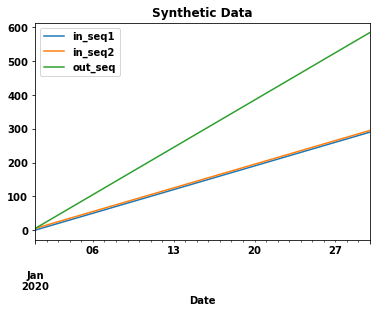

In [5]:
dataset.plot()
plt.title("Synthetic Data")

## Data Splitting
In Deep Learning, we often split our data into training and test dataset. The training data is used to train the model whereas the test data is used to validate the performance of the model.

In [6]:
# Calculate the split ratio 
split_data = round(len(dataset)*split_ratio)
split_data

21

In [7]:
# Split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
train_time = dataset.index[:split_data]
test_time = dataset.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Standardization
Standardize the data to have zero mean and unit variance in order to make our model converge faster.

In [8]:
scaler, train_data_standard, test_data_standard = data_module.multi_data_scaler(train_data,test_data,scale_mode = "Standardize")
print("train_data_standardized"+str(train_data_standard.shape))
print("test_data_standardized"+str(test_data_standard.shape))

train_data_standardized(21, 3)
test_data_standardized(9, 3)


## Data Sequencing
Sequencing the data by taking in a multivariate series into feature and label
<img src = "../../picture/multivariate univariate.png"  width="300" height  ="300" align="center" />

In [9]:
trainX, trainY = data_module.multivariate_univariate_multi_step(train_data_standard,window_size,n_step)
testX, testY = data_module.multivariate_univariate_multi_step(test_data_standard,window_size,n_step)


print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(17, 4, 2) trainY shape:(17, 2)

testX shape:(5, 4, 2) testY shape:(5, 2)


In [10]:
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY = testY.reshape(testY.shape[0],n_step,1)
print(f"trainY shape:{trainY.shape}")
print(f"testY shape:{testY.shape}")

trainY shape:(17, 2, 1)
testY shape:(5, 2, 1)


## Data Transformation
Data has to be transformed from NumPy to PyTorch tensor before being fed into the model. Furthermore, it is required to perform 3D Data Transformation when we are planning on developing an LSTM model.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [11]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

In [12]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([17, 4, 2])
train_data_y_label shape : torch.Size([17, 2, 1])
test_data_x_feature shape : torch.Size([5, 4, 2])
test_data_y_label shape : torch.Size([5, 2, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [13]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

## Input Model
The model should be inputted with all required attributes such as number of input layers, output layers and hidden layers.

How to Use :

Select one of the model bases in the cell and comment out other models.<br>
IF use Vanilla LSTM , set num_layer = 1 and use the model = LSTM()<br>
IF use Stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
IF use Bidirectional LSTM, use the model = BidirectionalLSTM()

In [14]:
# Arguments for LSTM model
hidden_dim = 32
number_of_time_series = trainX.shape[2] 

# num_layers : 1 for vanilla LSTM , >1 is for stacked LSTM
num_layers = 1
 

#Vanilla , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = number_of_time_series, 
                                  hidden_dim = hidden_dim ,
                                  num_layers = num_layers , 
                                  n_step = n_step )

#Bidirectional LSTM
# model = deep_learning_module.BidirectionalLSTM(n_feature = number_of_time_series, 
#                                                hidden_dim = hidden_dim ,
#                                                num_layers = num_layers , 
#                                                n_step = n_step)

Define MSE as the loss function and use Adam as the model optimizer.

In [15]:
# Use MSE as loss function 
loss_fn = torch.nn.MSELoss()

# Optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# print the summary of the LSTM model
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))
batch_size

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [1, 4, 32]    4608       4352
1_fc        [32, 2]       [1, 2]      66         64
---------------------------------------------------
                      Totals
Total params            4674
Trainable params        4674
Non-trainable params       0
Mult-Adds               4416
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [1, 4, 32]    4608       4352
1_fc        [32, 2]       [1, 2]      66         64


1

# Step 3 : Training
>**Instruction** : <br>
Use `deep_learning_module.training` to train the model.

In [17]:
#seed
torch.manual_seed(123)

# Start Training
train_loss,val_loss = deep_learning_module.training(num_epochs = num_epochs,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model)

# Step 4 : Validation
A train loss and val loss is plotted to define how well the data fits into the model.

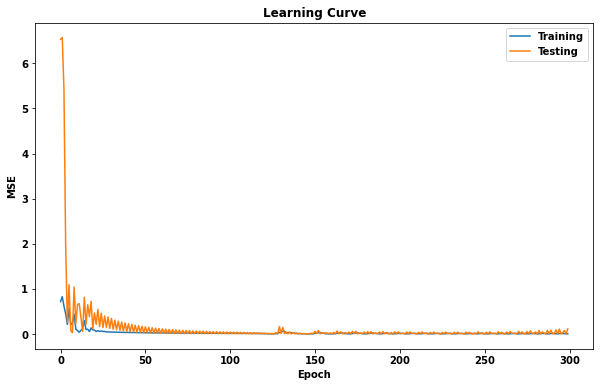

Epoch : 0 , training loss : 0.7184968448298819 , validation loss : 6.532531356811523
Epoch : 1 , training loss : 0.8296849243342876 , validation loss : 6.574133396148682
Epoch : 2 , training loss : 0.6176418363226249 , validation loss : 5.4194801330566404
Epoch : 3 , training loss : 0.45034290570080937 , validation loss : 1.9778761386871337
Epoch : 4 , training loss : 0.21098322973600314 , validation loss : 0.25853811800479887
Epoch : 5 , training loss : 0.5659901094896829 , validation loss : 1.0919748902320863
Epoch : 6 , training loss : 0.20965512373539455 , validation loss : 0.07508319532498717
Epoch : 7 , training loss : 0.2357226536842063 , validation loss : 0.029582480224780737
Epoch : 8 , training loss : 0.4361646568457432 , validation loss : 1.0406222343444824
Epoch : 9 , training loss : 0.10660229063839377 , validation loss : 0.2249377965927124
Epoch : 10 , training loss : 0.07573854408612052 , validation loss : 0.6566842675209046
Epoch : 11 , training loss : 0.038297978817033

In [18]:
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determining the output forecast value and calculate the RMSE. For this tutorial, we will use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [19]:
# Section 1 : make predictions
y_train_prediction = model(train_data_dict['train_data_x_feature'])
y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [20]:
# Assign evaluation key
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
    y_test_prediction,
    train_data_dict,
    test_data_dict)
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

In [21]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([17, 2])
test_data_output shape : torch.Size([5, 2])


In [22]:
# Section 3 : Invert predictions
data_scaler = scaler[list(scaler)[-1]]
prediction = data_module.inverse_scaler(prediction,data_scaler)
output_data  = data_module.inverse_scaler(output_data ,data_scaler)

In [23]:
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (17, 2)
test_data_prediction shape : (5, 2)
train_data_output shape : (17, 2)
test_data_output shape : (5, 2)


In [24]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[485. 505.]		[460.49533 485.658  ]
[505. 525.]		[473.40594 499.755  ]
[525. 545.]		[484.41214 511.98923]
[545. 565.]		[493.33102 522.13586]
[565. 585.]		[500.0985  530.07965]


In [25]:
# Section 4 : Calculate the RMSE of train and test data
trainScore,testScore = data_module.rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15.00 RMSE
Test Score: 41.33 RMSE


# Step 6 : Forecast Plot
A similar concept to the forecast plot in multivariate input, univariate output single step, you need to add an extra `test_time[window_size-1:]` and the condition to the function `multivariate = False`. Please refer to [04 - LSTM_Multivariate_Univariate_SingleStep **# Step 6 : Forecast Plot**](./04%20-%20LSTM_Multivariate_Univariate_SingleStep.ipynb) for explanation.

In [26]:
from matplotlib.lines import Line2D
def multi_step_plot(original_test_data,
                    after_sequence_test_data ,
                    forecast_data,test_time,window_size,
                    n_step ,
                    details = {},
                    original_plot = False,
                    multivariate = False):
    
    """ 
    Plot the result of multi-step forecast 
    
    Arguments:
    original_test_data -- test data before sequence
    after_sequence_test_data -- (dict) output data dictionary
    forecast_data -- (dict) prediction data dictionary
    test_time -- time index for test data before sequence
    window_size -- window size for the data sequence
    n_step -- the number of future step , 1 -> single >1 -> multi-step
    details -- (dict) details for plot such as "x-axis" ,"y-axis", "title"
    original_plot -- (boolean) True ->observe how sliding window (data sequence) take place in the test data
    
    """
    
    after_sequence_test_data = after_sequence_test_data['test_data_output'] 
    forecast_data = forecast_data["test_data_prediction"]
    
    
    
    # Plot Setting
    plt.figure(figsize=(10,6))
    plt.xticks(rotation=45)    
    
    # Store test and forecast data into DataFrame type 
    column_names = ["timestep_" + str(i) for i in range(after_sequence_test_data.shape[1])]
    y_test_dataframe = pd.DataFrame(after_sequence_test_data,columns = column_names)
    y_test_pred_dataframe =pd.DataFrame(forecast_data,columns = column_names)
    
    # Create time index for data after sequence
    if multivariate:
        time_index_after_sequence = test_time[window_size-1:]
        
    else:
        time_index_after_sequence = test_time[window_size:]
    
    # Test Data plot before sliding window(data sequencing)
    if original_plot:
        plt.plot(test_time,original_test_data,marker='x',color="blue")

    # For loop to plot the data step by step base on time index    
    start_idx = 0 
    for row in range(len(y_test_dataframe)):
        
               
        # Iterate the time index after sequence
        time_index = time_index_after_sequence[start_idx:start_idx+n_step]
        
        
        
        # Plot the test data
        plt.plot(time_index,y_test_dataframe.iloc[row],color="green",marker='o')
        
        # Plot the forecast data
        plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')
        
        # Pointer for time_index_after_sequence
        start_idx += 1
        
    # Customize the legend
    custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
    plt.legend(custom_lines, ['Test Data After Sequencing', 'Forecast Data', 'Test Data Before Sequencing'])
    
    # Extra details - Optional function
    if details != {}:
        plt.xlabel(details["x-axis"])
        plt.ylabel(details["y-axis"])
        plt.title(details["title"])

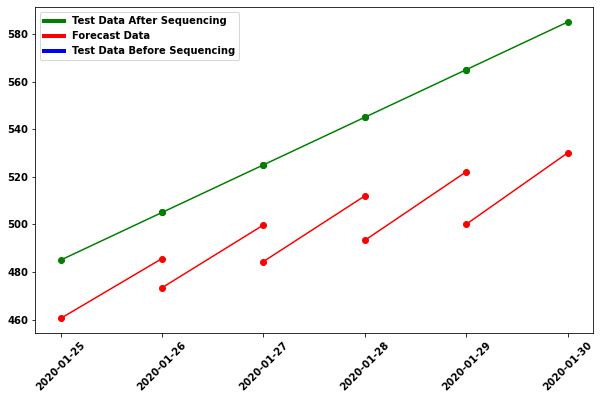

In [27]:
multi_step_plot(original_test_data = test_data["out_seq"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=False,
                            multivariate = True)

# Part 2 : Exercise for Multivariate Multi-step
## Task : Predict total number of death case in COVID-19 Malaysia 3 day in future

### Introduction 
You are given a set of data that contain information about COVID-19 cases worldwide. You are required to perform some data analysis on it and predict the death cases.<br>

Please follow the instruction and try to code the exercise. Please feel free to google to find out how to use a particular function in the data exploration part.<br>



Data Source : 
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

## Hyperparameter
>**Instruction** : <br>
You are required to fill the `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 10 RMSE<br>
Test Score <= 10 RMSE<br>

In [28]:
#Hyperameter
split_ratio_covid = 0.70
num_epochs_covid = 100
window_size_covid = 5
n_step_covid = 3
learning_rate_covid = 0.001
batch_size_covid = 5
#seed
torch.manual_seed(123)

# Step 1 : Data Preparation
In this tutorial, you will face a complex real-world dataset. You are required to use some of the data exploration technique to help you prepare the data.

>**Instruction** : <br>
Read the file using `pd.read_csv`<br>
Save your data as `cases`<br>
Your file path `../../datasets/others/covid_19_data.csv`

In [29]:
### BEGIN SOLUTION
cases = pd.read_csv("../../datasets/others/covid_19_data.csv")
### END SOLUTION
cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


As you can see, the data contains info on COVID-19 cases from other countries as well. Hence, you need to slice the COVID-19 info to extract the data relevant to Malaysia.

>**Instruction** : <br>
Slice the COVID-19 info only for Malaysia. You might need to use `df.loc[]` to help you slice the data.

>**Expected Result** :<br>
Example of the first 5 rows:

---	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
78	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
168	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
214	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
260	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
311	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0

In [30]:
cases["Country/Region"].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [31]:
### BEGIN SOLUTION
new_covid_data = cases.loc[cases["Country/Region"] == 'Malaysia']
new_covid_data.head()
### END SOLUTION

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
78,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
168,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
214,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
260,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
311,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


We need to make sure there is no missing value in our data
>**Instruction** : <br>
Use `df.isnull().values.any()` to check any missing data in our dataset. `True` is meant there is `NaN` in our dataset<br>
Most of the columns does not contain `NaN` except for `Province/State `. This is acceptable for the time being as this column will be dropped later due to its insignificance in our goal.

>**Expected Result** :<br>

Columns|Status
---|---
SNo                |False
ObservationDate    |False
Province/State      |True
Country/Region     |False
Last Update        |False
Confirmed          |False
Deaths             |False
Recovered          |False


In [32]:
### BEGIN SOLUTION
new_covid_data.isnull().any()
### END SOLUTION

SNo                False
ObservationDate    False
Province/State      True
Country/Region     False
Last Update        False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool

>**Instruction** : <br>
Set the `ObservationDate` as the index for the dataset. You are required to convert `ObservationDate` to datetime using `pd.to_datetime()` <br>

>**Expected Result** :<br>
Example of the first 5 rows:

ObservationDate	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
01/23/2020	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
01/25/2020	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
01/26/2020	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
01/27/2020	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
01/28/2020	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0

In [33]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.set_index(pd.to_datetime(new_covid_data["ObservationDate"]))
### END SOLUTION

new_covid_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,,
2020-01-23,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
2020-01-25,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
2020-01-26,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
2020-01-27,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
2020-01-28,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


Columns such as `SNo`, `ObservationDate`, `Province/State`, `Country/Region`, and `Last Update` do not provide any useful information to us. Hence, we need to drop it to make the data look cleaner. 

>**Instruction** : <br>
Use `df.drop` to drop the `columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update']`<br>

>**Expected Result** :<br>

ObservationDate	|Confirmed	|Deaths	|Recovered
	---|---|---|---		
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|    0.0|	0.0

In [34]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.drop(columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update'])
### END SOLUTION
new_covid_data.head()


,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


To make the sliding window function work, you need to rearrange the data columns such a way that the targeted forecast series will be the last column of the data
>**Instruction** : <br>
Rearrage the data column using `df[]`<br>
For example : <br>
columns = [`A`,`B`,`C`]<br>
rearranged columns = [`A`,`C`,`B`]<br>
`df =  df[rearrage columns]`

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths
		---|---|---|---	
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|	0.0|	0.0

In [35]:
### BEGIN SOLUTION
new_covid_data = new_covid_data[["Confirmed","Recovered","Deaths"]]
### END SOLUTION
new_covid_data.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. Looking at the graph below, it is seen that there is an increasing trend in data.

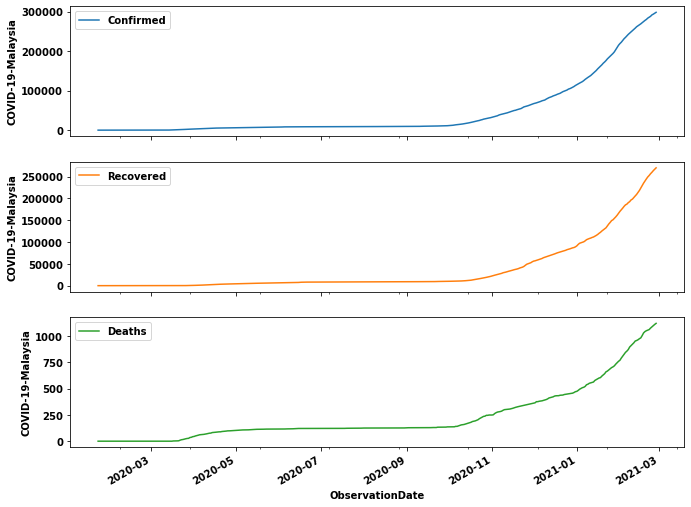

In [36]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

However, the data is in cumulative form. To perform time-series prediction, we need to convert the cumulative cases into daily cases.

>**Instruction** : <br>
Remove the cumulative count. You might need to use a `For loop` to loop through the data for each columns. Use `new_covid_data[name] - new_covid_data[name].shift().fillna(0)` as the math operation to remove the cumulative.<br>

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths|
	---|	---|---|---	
2020-01-23|	0.0|	0.0|	0.0|
2020-01-25|	3.0|	0.0|	0.0|
2020-01-26|	1.0|	0.0|	0.0|
2020-01-27|	0.0|	0.0|	0.0|
2020-01-28|	0.0|	0.0|	0.0|

In [37]:
### BEGIN SOLUTION
for name in new_covid_data.columns:
        new_covid_data[name] = new_covid_data[name] - new_covid_data[name].shift().fillna(0)
### END SOLUTION
new_covid_data.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,1.0,0.0,0.0
2020-01-27,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0


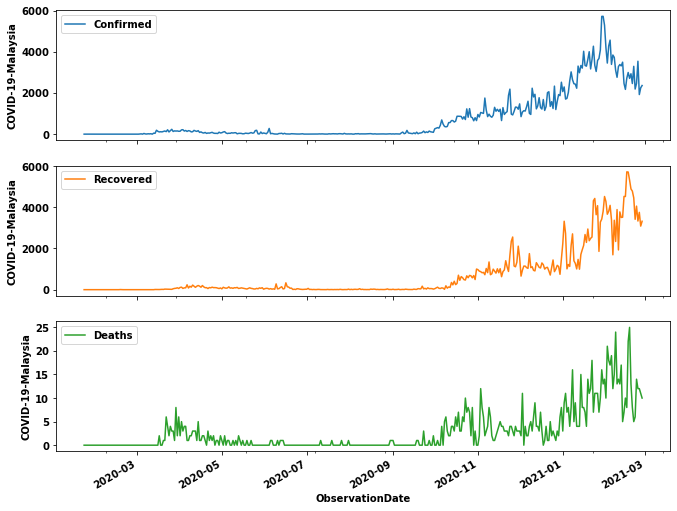

In [38]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model where the test data is used to validate the performance of the model.

In [39]:
split_data_covid = round(len(dataset)*split_ratio)
split_data_covid

21

In [40]:
# Split data by indexing 
train_data_covid = new_covid_data[:-split_data_covid ]
test_data_covid = new_covid_data[-split_data_covid :]
train_time_covid = new_covid_data.index[:-split_data_covid ]
test_time_covid = new_covid_data.index[-split_data_covid :]

print("train_data_shape")
print(train_data_covid.shape)
print("test_data_shape")
print(test_data_covid.shape)

train_data_shape
(380, 3)
test_data_shape
(21, 3)


## Data Normalization 
Normalize the data into a range of 0 to 1

In [41]:
scaler_covid,train_data_normalized_covid,test_data_normalized_covid = data_module.multi_data_scaler(train_data_covid,
                                                                                         test_data_covid,
                                                                                         scale_mode = "Normalize")
print("train_data_normalized_demand"+str(train_data_normalized_covid.shape))
print("test_data_normalized_demand"+str(test_data_normalized_covid.shape))

train_data_normalized_demand(380, 3)
test_data_normalized_demand(21, 3)


## Data Sequencing
Sequencing the data by taking in the multivariate series into feature and label
<img src = "../../picture/multivariate univariate.png"  width="300" height  ="300" align="center" />

In [42]:
trainX_covid ,trainY_covid=  data_module.multivariate_univariate_multi_step(train_data_normalized_covid,window_size_covid,n_step_covid)
testX_covid , testY_covid = data_module.multivariate_univariate_multi_step(test_data_normalized_covid,window_size_covid,n_step_covid)
print(f"trainX_demand shape:{trainX_covid.shape} trainY_demand shape:{trainY_covid.shape}\n")
print(f"testX_demand shape:{testX_covid.shape} testY_demand shape:{testY_covid.shape}")

trainX_demand shape:(374, 5, 2) trainY_demand shape:(374, 3)

testX_demand shape:(15, 5, 2) testY_demand shape:(15, 3)


In [43]:
trainY_covid = trainY_covid.reshape(trainY_covid.shape[0],n_step_covid,1)
testY_covid= testY_covid.reshape(testY_covid.shape[0],n_step_covid,1)
print(f"trainY shape:{trainY_covid.shape}")
print(f"testY shape:{testY_covid.shape}")

trainY shape:(374, 3, 1)
testY shape:(15, 3, 1)


## Data Transformation
Data has to be transformed from NumPy to PyTorch tensor before being fed into the model. Furthermore, it is required to perform 3D Data Transformation when we are planning on developing an LSTM model.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [44]:
### BEGIN SOLUTION
train_data_dict_covid ,test_data_dict_covid = data_module.key_assign(trainingX = trainX_covid  , 
                       testingX = testX_covid, 
                       trainingY = trainY_covid, 
                       testingY = testY_covid)
train_data_dict_covid ,test_data_dict_covid = data_module.transform(train_data_dict_covid ,test_data_dict_covid)
### END SOLUTION

In [45]:
data_module.sanity_check(train_data_dict_covid , test_data_dict_covid)

train_data_x_feature shape : torch.Size([374, 5, 2])
train_data_y_label shape : torch.Size([374, 3, 1])
test_data_x_feature shape : torch.Size([15, 5, 2])
test_data_y_label shape : torch.Size([15, 3, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [46]:
### BEGIN SOLUTION
train_iter_covid , test_iter_covid = data_module.iterator(train_data_dict_covid ,
                                                          test_data_dict_covid,
                                                          batch_size = batch_size_covid)
### END SOLUTION

## Input Model
The model should be inputted with all required attributes such as number of input layers, output layers and hidden layers.

How to Use :

1. Select one of the model bases in the cell and comment out other models.<br>
2. IF use Vanilla LSTM , set num_layer = 1 and use the model = LSTM()<br>
3. IF use Stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
4. IF use Bidirectional LSTM, use the model = BidirectionalLSTM()

>**Instruction** :\
Import the LSTM model from `deep_learning_module`. You are required to import both Vanilla LSTM and Bidirectional LSTM and save it as `model`

In [47]:
#seed
torch.manual_seed(123)
### BEGIN SOLUTION
#Arguments for LSTM model
hidden_dim_covid = 32
n_feature_covid = trainX_covid.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_covid = 1


#Vanilla , Stacked LSTM
model_covid = deep_learning_module.LSTM(n_feature = n_feature_covid, 
                                        hidden_dim = hidden_dim_covid ,
                                        num_layers = num_layers_covid , 
                                        n_step = n_step_covid )

#Bidirectional LSTM
# model_demand = deep_learning_module.BidirectionalLSTM(n_feature = n_feature_covid, 
            #                                         hidden_dim = hidden_dim_covid ,
            #                                         num_layers = num_layers_covid , 
            #                                         n_step = n_step_covid)
            
### END SOLUTION

In [48]:
#loss function 
loss_fn_covid = torch.nn.MSELoss()

#optimiser
optimizer_covid = torch.optim.Adam(model_covid.parameters(), lr=learning_rate_covid)

In [49]:
# print the summary of the LSTM model
inputs = torch.zeros((batch_size_covid,window_size_covid,trainX_covid.shape[2]),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model_covid,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [5, 5, 32]    4608       4352
1_fc        [32, 3]       [5, 3]      99         96
---------------------------------------------------
                      Totals
Total params            4707
Trainable params        4707
Non-trainable params       0
Mult-Adds               4448
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [5, 5, 32]    4608       4352
1_fc        [32, 3]       [5, 3]      99         96


# Step 3 : Training
>**Instruction** : <br>
Use `deep_learning_module.training` to train the model.

In [50]:
#seed
torch.manual_seed(123)
### BEGIN SOLUTION

# Start training 
train_loss_covid,val_loss_covid = deep_learning_module.training(num_epochs= num_epochs_covid ,
                                                    train_iter = train_iter_covid,
                                                    test_iter = test_iter_covid ,
                                                    optimizer = optimizer_covid,
                                                    loss_fn = loss_fn_covid,
                                                    model = model_covid)
### END SOLUTION

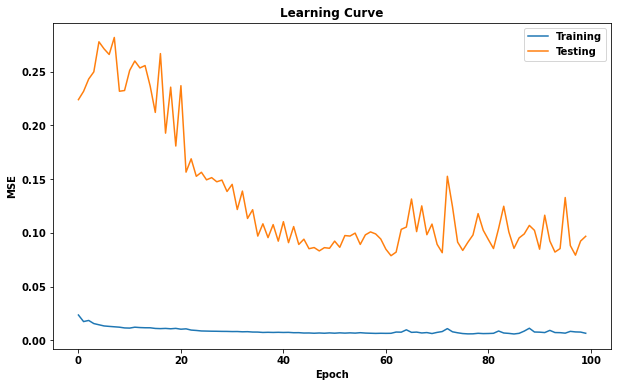

Epoch : 0 , training loss : 0.023637442468580874 , validation loss : 0.22390254338582358
Epoch : 1 , training loss : 0.01753509687320491 , validation loss : 0.2316015064716339
Epoch : 2 , training loss : 0.018574691512907627 , validation loss : 0.24307705958684286
Epoch : 3 , training loss : 0.015681033145361935 , validation loss : 0.24973461031913757
Epoch : 4 , training loss : 0.014560064299309202 , validation loss : 0.2777053117752075
Epoch : 5 , training loss : 0.01346330395392001 , validation loss : 0.2711446483929952
Epoch : 6 , training loss : 0.01305365677415145 , validation loss : 0.26589787503083545
Epoch : 7 , training loss : 0.01268471686355898 , validation loss : 0.2817295541365941
Epoch : 8 , training loss : 0.012320364810024485 , validation loss : 0.23171302924553552
Epoch : 9 , training loss : 0.01162286013197474 , validation loss : 0.23240593820810318
Epoch : 10 , training loss : 0.01147009513461965 , validation loss : 0.2511201451222102
Epoch : 11 , training loss : 0.

In [51]:
# Plot Learning Curve 
### BEGIN SOLUTION
data_module.learning_curve(num_epochs = num_epochs_covid,
                           train_loss = train_loss_covid ,
                           val_loss = val_loss_covid)

### END SOLUTION

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determining the output forecast value and calculate the RMSE. For this exercise, use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

>**Instruction** : <br>
Complete each section with a function from `data_module`

In [52]:
# Section 1 : Make predictions

### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction_covid = model_covid(train_data_dict_covid['train_data_x_feature'])
    y_test_prediction_covid = model_covid(test_data_dict_covid['test_data_x_feature'])
### END SOLUTION

In [53]:
# Assign evaluation key
### BEGIN SOLUTION
prediction_covid , output_covid = data_module.key_assign_evaluation(y_train_prediction_covid,
                                                                    y_test_prediction_covid,
                                                                    train_data_dict_covid,
                                                                    test_data_dict_covid)
### END SOLUTION

### BEGIN SOLUTION
# Squeeze the output dimension
output_data_covid = data_module.squeeze_dimension(output_covid)
### END SOLUTION

In [54]:
data_module.sanity_check(data_1 = output_data_covid,data_2 = {})

train_data_output shape : torch.Size([374, 3])
test_data_output shape : torch.Size([15, 3])


In [55]:
#Invert predictions
### BEGIN SOLUTION
scaler_covid_output = scaler_covid[list(scaler_covid)[-1]]
prediction_covid = data_module.inverse_scaler(prediction_covid,scaler_covid_output)
output_data_covid  = data_module.inverse_scaler(output_data_covid ,scaler_covid_output)
### END SOLUTION

`np.rint` is use to round our data to integer since the death cases should be in the integer form

In [56]:
prediction_covid['test_data_prediction'] = np.rint(prediction_covid['test_data_prediction'])
output_data_covid['test_data_output'] =  np.rint(output_data_covid['test_data_output']) 

In [57]:
# List the forecast value
### BEGIN SOLUTION
data_module.list_forecast_value(output_data_covid,prediction_covid) 
### END SOLUTION

Test Data			Forecast
[13. 17.  5.]		[11. 11. 11.]
[17.  5.  7.]		[12. 11. 12.]
[ 5.  7. 10.]		[13. 13. 14.]
[ 7. 10.  8.]		[11. 10.  9.]
[10.  8. 22.]		[10.  9.  8.]
[ 8. 22. 25.]		[10.  9.  8.]
[22. 25. 13.]		[9. 9. 7.]
[25. 13.  8.]		[9. 9. 7.]
[13.  8.  5.]		[9. 9. 7.]
[8. 5. 6.]		[10.  9.  7.]
[ 5.  6. 14.]		[10. 10.  8.]
[ 6. 14. 12.]		[10.  9.  7.]
[14. 12. 12.]		[10.  9.  7.]
[12. 12. 11.]		[11. 12. 13.]
[12. 11. 10.]		[9. 9. 7.]


In [58]:
# calculate root mean squared error
### BEGIN SOLUTION
trainScore_covid,testScore_covid = data_module.rmse(prediction_covid,output_data_covid)
print('Train Score: %.2f RMSE' % (trainScore_covid))
print('Test Score: %.2f RMSE' % (testScore_covid))
### END SOLUTION

Train Score: 1.68 RMSE
Test Score: 6.58 RMSE


# Step 6 : Forecast Plot

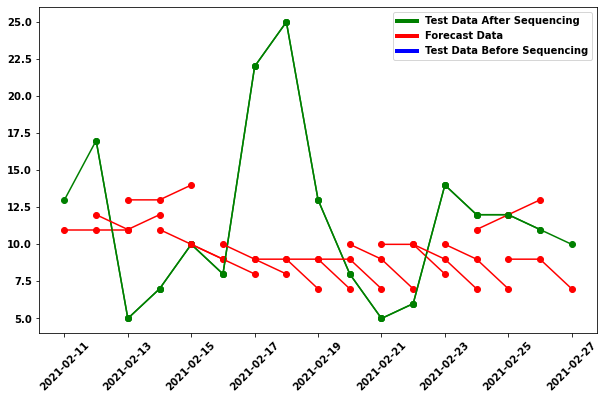

In [59]:
multi_step_plot(original_test_data = test_data_covid["Deaths"],
                            after_sequence_test_data = output_data_covid,
                            forecast_data = prediction_covid,
                            test_time = test_time_covid,
                            window_size = window_size_covid,
                            n_step = n_step_covid,
                            details={},
                            original_plot=False,
                            multivariate = True)


## Summary
In this tutorial you should have learned:

1. The pipeline of using LSTM perform multivariate input univariate output multi-step 
2. How to import function and class from Python module `data_module.py` and `deep_learning_module.py` 
3. Some basic data exploratory technique

Congratulations, that concludes this lesson.<br>

Please save the latest `multi_step_plot` function to the `data_module.py`


Please proceed to other notebooks for other types of data in LSTM forecasting <br>
1. ~~*[04 - LSTM_Univariate_SingleStep]*~~  *Complete*
2. ~~*[04 - LSTM_Univariate_MultiStep.ipynb]*~~ *Complete*
3. ~~[04 - LSTM_Multivariate_Univariate_SingleStep]~~ *Complete*
4. ~~[04 - LSTM_Multivariate_Univariate_MultiStep]~~*Complete*

## Reference
1. [Multistep Time Series Forecasting with LSTMs in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
2. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)